# Recommender systems - Project 4

## Abstract
In this project we will evaluate latent factor based recommender system on Movie Lens data set using ALS (Alternating Least Squares factorization method) and SGD (Stochastic Gradient Descent method). We will describe the logic behind these algorithms, provide a set of python functions to implement the algorithms, along with a set of python functions to develop a framework to test and evaluate our algorithms performance. We compare the performances of the algorithms using 3 metrics: The RMSE (Root Mean Squared Error), run time of the algorithms, and how good are the Area Under the Curve metric of ROC. The scalability of the algorithms are also evaluated by gradually increasing the amount of training data. 

## Importing all the required packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects that were created using webscraping
import pprint
from lxml import html
import requests
#from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import ShuffleSplit
import warnings
import itertools    
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse.linalg import svds

## Problem statement

In recommendation systems, we have a Utility matrix that shows the affinity of all users towards all available items. But this Utility matrix is very sparse, since most of the users might not have looked or experienced all items, and the main goal of recommender systems is to identify the potential items the user might be interested in. One way to accomplish this goal is based on matrix factorization method. We have to express the Utility matrix as a product of two matrices, to estimate the missing entries in the Utility matrix. In mathematical terms, we define our main objective as given below. 

_Objective_: Express the matrix M as a product of U and V. Where _M_ is a _mXn_ matrix, _U_ is a _mXd_ matrix and _V_ is a _dXn_ matrix, where _d_ is the number of latent factors. 


Mathematically, let
$$M=\left[ \begin{array}{cccccc} r_{11} & r_{12} & . & . & r_{1n} \\ r_{21} & r_{22} & . & . & r_{2n} \\ r_{31} & r_{32} & . & . & r_{3n} \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . & r_{mn} \end{array} \right]$$
$$U=\left[ \begin{array}{ccc} u_{11} & . & u_{1d} \\ u_{21} & . & u_{2d} \\  u_{31} & . & u_{3d} \\ . & . & . \\ .& . & . \\ u_{m1} & . & u_{md} \end{array} \right]$$ 
$$V=\left[ \begin{array}{ccccc} v_{11} & v_{12} & . & . & v_{1n} \\ v_{21} & v_{22} & . & . & v_{2n} \\ . & . & . & . & . \\v_{d1} & v_{d2} & . & . & v_{dn}\end{array} \right]
$$

Then M can be expressed as the matrix product of U and V, as shown below: 
$$\left[ \begin{array}{cccccc} r_{11} & r_{12} & . & . & r_{1n} \\ r_{21} & r_{22} & . & . & r_{2n} \\ r_{31} & r_{32} & . & . & r_{3n} \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . & r_{mn} \end{array} \right] = 
\left[ \begin{array}{ccc} u_{11} & . & u_{1d} \\ u_{21} & . & u_{2d} \\  u_{31} & . & u_{3d} \\ . & . & . \\ .& . & . \\ u_{m1} & . & u_{md} \end{array} \right] \left[ \begin{array}{ccccc} v_{11} & v_{12} & . & . & v_{1n} \\ v_{21} & v_{22} & . & . & v_{2n} \\ . & . & . & . & . \\v_{d1} & v_{d2} & . & . & v_{dn}\end{array} \right] $$

In recommender systems, the matrix M is a sparse matrix with many unknown entries. An example of such sparse matrix is shown below:

$$M=\left[ \begin{array}{cccccc}  & r_{12} & . & . & r_{1n} \\ r_{21} &   & . & . & r_{2n} \\ r_{31} &   & . & . &   \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . &   \end{array} \right]$$

For such sparse matrices, we cannot use SVD method to factorize the matrix. Hence from recommendation systems perspective, our main objective is to estimate the U and V matrices considering only the available data in M. Once we obtain optimal U and V matrices (based on the available data in M), we can get the matrix product UV, and estimate an approximate value of the missing elements in M, by comparing the corresponding elements between M and UV. Another advantage of U, V factorization is to identify the hidden dimensions (also called latent factors), which map both the user and items to a common set of dimensions/coordinate system. Such mapping will help to identify users/items/user-item pairs, which are near to each other.

Two of the prominent methods to estimate the U and V matrices are: 

* Alternating Least Squares (ALS) 

* Gradient descent method (Stochastic Gradient Descent or SGS)

The logic of algorithms is explained given below:

### Alternating Least Squares Algorithm

1. Initialize U and V matrices to random real numbers (you may use a std. normal distribution with mean 0, variance 1)
2. Let i represent row number in U and j represent the column number in V
3. To estimate the row $U_i$, perform the following:

   3a. Get the list of all columns in $M_i$ row, where we have available values. Call these locations as C

   3b. Let $V_C = V[:,C]$, where $V[:,C]$ is the list of all columns in V, corresponding to the column numbers present in C
   
4. Estimate new value of $U_i$ as:
$$U^{new}_{i} = {(\lambda_1.I + V_C . V^T_C)}^{-1} (V_C . M^T_i)$$ where $I$ is an indentity matrix of size equal to d

5. Update $U_i = {(U^{new}_{i})}^T$

6. To estimate the column $V_j$, perform the following:
   
   6a. Get the list of all rows in $M_j$ column, where we have available values. Call these locations as R
   
   6b. Let $U_R = U[R,:]$, where $U[R,:]$ is the list of all rows in U, corresponding to the row numbers present in R
7. Estimate new value of $V_j$ as:
$$V^{new}_{j} = {(\lambda_2.I + U^T_R . U_R)}^{-1} (U^T_R . M_j)$$ where $I$ is an indentity matrix of size equal to d

8. Update $V_j = V^{new}_j$

9. Get the U.V 

10. Subtract the available values of R from the corresponding values of U.V. Square the resulting values, sum them and take the square root to obtain RMSE (Root Mean Squared Error)

11. Repeat steps 3 to 10, until desired number of iterations or until RMSE is stablized

Note: The $\lambda_1$ and $\lambda_2$ are regularization parameters. We have to tune these parameters to optimal values. 




### Stochastic Gradient Descent (SGD)

1. Initialize U and V to random values. We can assume 0s for NA values in M, use SVD method to obtain U and V, and use these values as the initial values of U and V.

2. Randomly choose U or V

3. If U is chosen, randomly choose a row _i_ from U. To estimate the row $U_i$, perform the following:

   3a. Get the list of all columns in $M_i$ row, where we have available values. Call these locations as C

   3b. Let $V_C = V[:,C]$, where $V[:,C]$ is the list of all columns in V, corresponding to the column numbers present in C
   
   3c. Estimate new value of $U_i$ as:
$$U^{new}_{i} = U_{i} - \alpha \nabla_{U_{i}} f_{ij}(U_i,V_i)$$ where $\alpha$ is the learning rate, and $\nabla_{U_i}f_{ij}(U_i,V_j)$ is defined as follows:
$$\nabla_{U_i}f_{ij}(U_i,V_j) = [M_i - U_i.V_C].V_C^T + \lambda_1 U_i$$ where $\lambda_1$ is the regularization parameter

4. If V is chosen, randomly choose a column _j_ from V. To estimate the column $V_j$, perform the following:

   4a. Get the list of all rows in $M_j$ column, where we have available values. Call these locations as R

   4b. Let $U_R = U[R,:]$, where $U[R,:]$ is the list of all rows in U, corresponding to the row numbers present in R
   
   4c. Estimate new value of $V_j$ as:
$$V^{new}_{j} = V_{j} - \alpha \nabla_{V_{j}} f_{ij}(U_i,V_i)$$ where $\alpha$ is the learning rate, and $\nabla_{V_{j}}f_{ij}(U_i,V_j)$ is defined as follows:
$$\nabla_{V_{j}}f_{ij}(U_i,V_j) = [M_j - U_R.V_j]^T.U_R + \lambda_2 V_j$$ where $\lambda_2$ is the regularization parameter




### Implementation of ALS

To implement the ALS algorithm in python, we will code the following 4 functions functions:

**ALS_factorization(M,d, lambda1, lambda2, n, error_diff, seed)**
This function will call the following two functions in the following fashion:
Start estimating the first row of U, using ALS_compute_U_row(0,M,V,d,lambda1), followed by estimating the first column of V using ALS_compute_V_col(0,M,U,d,lambda2), then repeat the same for the second row of U followed by the second column of V, and so on. If the last row in U or last column in V is reached repeat the same process again with 0 row or column number respectively. In between the calls, estimate the RMSE (Root Mean Squared Error), and stop if there is no significant change in RMSE. As per "Chapter 9 of Mining Massive Datasets", the key idea is to update the elements of U and V in a specific order. If the elements are not updated in a specific order, then the RMSE would not stablize.

The first parameter is M (utility matrix), the second parameter is _d_ (the desired number of latent factors), the third parameter is _lambda1_ (regularization factor for computing U's row), _lambda2_ (regularization factor for computing V's column), _n_ is the maximum number of iterations, and *error_diff* is the least acceptable error difference between the consecutive iterations. The algorithm stops updating the elements of U and V once the specified number of tretations is reached or when the error difference between consecutive iterations is less than or equal to *error_diff*. The *seed* helps us to get the reproduciable results.

**ALS_compute_U_row(i,M,V,d,lambda1)**
This function will accept 5 variables as inputs, and computes a specific row in U, while keeping all other U and V elements constant. The parameters details are given below:

i = desired row number in U that needs to be estimated (row numbers begin from 0)

M = Utility matrix, which needs to be factorized

V = V matrix or factor in the expression M = UV

d = desired number of latent factors or columns in U

lambda1 = regularization parameter


**ALS_compute_V_col(j,M,U,d,lambda2)**
This function will also accept 5 variables as inputs, and computes a specific column in V, while keeping all other U and V elements constant. The parameters details are given below:

j = desired column number in V that needs to be estimated (column numbers begin from 0)

M = Utility matrix, which needs to be factorized

U = U matrix or factor in the expression M = UV

d = desired number of latent factors or rows in V

lambda2 = regularization parameter

**get_RMSE(M,U,V)**
This function will compute the RMSE between M and UV, considering the available elements only in M. Takes 3 parameters M, U and V. M is the Utility matrix, U is the U component and V is the V component in M = UV




In [2]:
def get_RMSE(M,U,V):
    return np.sqrt(np.nanmean(np.square(M - np.dot(U,V))))

def ALS_compute_U_row(i,M,V,d,lambda1):
    '''
     i = desired row number in U, which needs to be computed
     M = Utility matrix of size mXn
     V = V component of size dXn
     lambda1 = reg factor
    '''
    import numpy as np
    num_of_rows, num_of_cols = M.shape
    
    #Get the locations where the M[i,] or row-i in M has genuine values
    C = np.where(~np.isnan(M[i,]))[0]

    #Get the columns from V, where the corresponding columns in M[i,] have genuine values 
    V_C = V[:,C].copy()
    
    M_i = M[i,:].copy()
    
    M_i = M_i[~np.isnan(M_i)]
    
    return np.dot(np.linalg.inv(np.eye(d) * lambda1 + np.dot(V_C,V_C.T)),np.dot(V_C,M_i.T).T)


def ALS_compute_V_col(j,M,U,d,lambda2):
    '''
     j = desired column number in V, which needs to be computed
     M = Utility matrix of size mXn
     U = U component of size mXd
     lambda2 = reg factor
    '''
    num_of_rows, num_of_cols = M.shape
  
    #Get the locations where the M[,i] or column-j in M has genuine values
    R = np.where(~np.isnan(M[:,j]))[0]
    
    #Get the rows from U, where the corresponding rows in M[,j] have genuine values
    U_R = U[R,:].copy()
    M_j = M[:,j].copy()
    M_j = M_j[~np.isnan(M_j)]
    return np.dot(np.linalg.inv(np.eye(d) * lambda2 + np.dot(U_R.T,U_R)),np.dot(U_R.T,M_j).T).T

def ALS_factorization(M,d, lambda1, lambda2, n, error_diff, seed):
    import numpy as np
    #Initialize U and V
    M_rows, M_cols = M.shape
    #np.random.seed(seed)
    #U = np.zeros((M_rows,d),dtype=np.float)+np.random.rand(M_rows,d)
    #np.random.seed(seed)
    #V = np.zeros((d,M_cols),dtype=np.float)+np.random.rand(d,M_cols)
    M_non_nan = np.nan_to_num(M)
    U, s, vt = svds(M_non_nan, k=d, ncv=None, tol=0, which='LM', 
                             v0=None, maxiter=None, return_singular_vectors=True)
    #print U
    #print np.dot(np.diag(s),vt)
    #print vt
    V = np.dot(np.diag(s),vt)

    i = 0
    j = 0
    error = []
    
    #Get the initial error
    error.append(get_RMSE(M,U,V))
    
    for count in xrange(n):
        #Save the current U and V values. 
        #These are needed, in case the error increases in the last iteration
        U_past = U.copy()
        V_past = V.copy()

        U_row_number = i%M_rows
        U[U_row_number,]=ALS_compute_U_row(U_row_number,M,V,d,lambda1)
        error.append(get_RMSE(M,U,V))
        if np.absolute(error[-2] - error[-1]) <= error_diff:
            return [U_past, V_past, error]
        V_col_number = j%M_cols
        V[:,V_col_number]=ALS_compute_V_col(V_col_number,M,U,d,lambda2)
        error.append(get_RMSE(M,U,V))
        if np.absolute(error[-2] - error[-1]) <= error_diff:
            return [U_past, V_past, error[:-1]]
        i = i+1
        j = j+1
    return [U, V, error]

### Implementation of SGD

We will code the following 4 functions functions to compute U and V using SGD method:

**SGD_factorization(M,d, lambda1, lambda2, n, error_diff, seed,alpha)**
In SGD we will estimate the row of U or column of V by choosing randomly U or V and choosing the row from U or column from V randomly. The randomness in choosing the elements is important. The function SGD_factorization function will accept 8 parameters. The first parameter is M (utility matrix), the second parameter is _d_ (the desired number of latent factors), the third parameter is _lambda1_ (regularization factor for computing U's row), _lambda2_ (regularization factor for computing V's column), _n_ is the maximum number of iterations, and *error_diff* is the least acceptable error difference between the consecutive iterations, _seed_ will accept a number which can be used to reproduce the results, and _alpha_ is the learning rate. The algorithm stops updating the elements of U and V once the specified number of iterations is reached or when the error difference between consecutive iterations is less than or equal to *error_diff*


**SGD_compute_U_row(i,M,V,d,lambda1)**
This function will accept 5 variables as inputs, and computes the gradient for a specific row in U, while keeping all other U and V elements constant. The parameters details are given below:

i = desired row number in U that needs to be estimated (row numbers begin from 0)

M = Utility matrix, which needs to be factorized

V = V matrix or factor in the expression M = UV

d = desired number of latent factors or columns in U

lambda1 = regularization parameter


**SGD_compute_V_col(j,M,U,d,lambda2)**
This function will also accept 5 variables as inputs, and computes the gradient for a specific column in V, while keeping all other U and V elements constant. The parameters details are given below:

j = desired column number in V that needs to be estimated (column numbers begin from 0)

M = Utility matrix, which needs to be factorized

U = U matrix or factor in the expression M = UV

d = desired number of latent factors or rows in V

lambda2 = regularization parameter

**get_RMSE_error(M,U,V)**
This function will compute the RMSE between M and UV, considering the available elements only in M. Takes 3 parameters M, U and V. M is the Utility matrix, U is the U component and V is the V component in M = UV. This function is a common function that would be used by both ALS and SGD method to estimate the error between the computations.

The following block implements the SGD algorithm. 


In [4]:
def SGD_compute_U_row(i,M,U,V,d,lambda1,alpha):
    '''
     i = desired row number in U, which needs to be computed
     M = Utility matrix of size mXn
     V = V component of size dXn
     lambda1 = reg factor
    '''
    num_of_rows, num_of_cols = M.shape
   
    #np.where will return a tuple.
    C = np.where(~np.isnan(M[i,]))[0]
    
    V_C = V[:,C].copy()
    M_i = M[i,:].copy()
    M_i = M_i[~np.isnan(M_i)]
    return alpha*(-1*np.dot((M_i - np.dot(U[i,],V_C)),V_C.T) + lambda1 * U[i,])
    
def SGD_compute_V_col(j,M,U,V,d,lambda2,alpha):
    '''
     j = desired column number in V, which needs to be computed
     M = Utility matrix of size mXn
     U = U component of size mXd
     lambda2 = reg factor
    '''
    num_of_rows, num_of_cols = M.shape
    
    #np.where will return a tuple.
    R = np.where(~np.isnan(M[:,j]))[0]
    
    U_R = U[R,:].copy()
    M_j = M[:,j].copy()
    M_j = M_j[~np.isnan(M_j)]
    return alpha*(-1*np.dot((M_j - np.dot(U_R,V[:,j])).T,U_R) + lambda2 * V[:,j])


def SGD_factorization(M,d, lambda1, lambda2, n, error_diff, seed,alpha):
    import numpy as np
    #Initialize U and V
    M_rows, M_cols = M.shape
    M_non_nan = np.nan_to_num(M)

    U, s, vt = svds(M_non_nan, k=d, ncv=None, tol=0, which='LM', 
                             v0=None, maxiter=None, return_singular_vectors=True)
    #print U
    #print np.dot(np.diag(s),vt)
    #print vt
    V = np.dot(np.diag(s),vt)
    #print "In SGD Factorization..."
    #print "U.shape:{}".format(U.shape)
    #print "V.shape:{}".format(V.shape)
    
    #print V
    #np.random.seed(seed)
    #U = np.zeros((M_rows,d),dtype=np.float)+np.random.rand(M_rows,d)
    #np.random.seed(seed)
    #V = np.zeros((d,M_cols),dtype=np.float)+np.random.rand(d,M_cols)
    error = []
    error.append(get_RMSE(M,U,V))

    for count in xrange(n):
            #Do not use any seed here
            #pick_1 = np.random.random_integers(0,1)
            pick_1 = np.random.randint(0,2)
            if pick_1 == 0:
                #pick_2 = np.random.random_integers(0,M_rows - 1)
                pick_2 = np.random.randint(0,M_rows)
                U[pick_2,] = U[pick_2,] - SGD_compute_U_row(pick_2,M,U,V,d,lambda1,alpha)
                error.append(get_RMSE(M,U,V))
                if np.absolute(error[-2] - error[-1]) <= error_diff:
                    return [U, V, error]
            else:
                #pick_2 = np.random.random_integers(0,M_cols-1)
                pick_2 = np.random.randint(0,M_cols)
                V[:,pick_2] = V[:,pick_2] - SGD_compute_V_col(pick_2,M,U,V,d,lambda2,alpha)
                error.append(get_RMSE(M,U,V))        
                if np.absolute(error[-2] - error[-1]) <= error_diff:
                    return [U, V, error]
    return [U, V, error]

## Data pre-processing

Now that we defined the required functions for ALS and SGD, let us prepare the data to evaluate the ALS and SGD methods.

The MovieLens data has several files, but we will use the following files for this project:
1. u.user (a tab delimited data set, containing the users details - users uniquely identified by user_id key)
2. u.item (a tab delimited data set, containing the movie details - movies uniquely identified by item_id)
3. u.data (a tab delimited data set, containing the user_id, item_id and the rating given to the item by the user)

### Reading the files 

We will read the u.data, u.user and u.item files, and extract the required columns (since we do not need all the columns for this project). Follow the comments in the code to know which columns are dropped. 

In [6]:
#Reading the movie information
movie_df=pd.read_table("u.item",sep="|" ,header=None)
#display(movie_df.head())
#Selecting only the needed columns: "item_id","item_name" from u.item data set
movie_url = movie_df[[0,1,4]]
movie_url.columns = ["item_id","item_name","item_url"]
movie_df=movie_df[[0,1]]
movie_df.columns = ["item_id","item_name"]

#Displaying sample data
print "Movie data frame sample rows:"
display(movie_df.head())

#Reading the user ID information, and 
#selecting columns: "user_id","age","gender","profession","zip". But we will not use the 
#gender, age, profession, zip
user_df=pd.read_table("u.user",sep="|" ,header=None)
user_df.columns=["user_id","age","gender","profession","zip"]

print "User data frame sample rows:"
display(user_df.head())

#Reading the user, movie ratings information
ratings_df=pd.read_csv("u.data",delimiter = "\t",header=None)
ratings_df.columns = ["user_id",  "item_id","rating","timestamp"]
#Dropping the timestamp info, since we do not need that information in this project
del ratings_df["timestamp"]

print "Displaying the ratings details (mapping between user id and item id):"
display(ratings_df.head())

Movie data frame sample rows:


,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


User data frame sample rows:


,user_id,age,gender,profession,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Displaying the ratings details (mapping between user id and item id):


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


## Building the framework for algorithms evaluation

We need to build the following functions to successfully evaluate the algorithms performance:

* Select a desired number of users randomly. This will help us to test the scalability of our algorithms

* Create a Utility matrix based on the selected users-rating data

* The Utility matrix, will be split into test and training data (20:80 for test:training respectively). A function will be written to perform this split. If only one rating is available for an item, the function must eliminate such item's rating from test data. The split must be random

* Define a function to obtain the ratings present at the the intersection of User-Items of the Utility matrix

* Define a function to normalize the data

* Define a function to plot the ROC curves

* Use the above functions and evaluate the algorithms performance by increasing the number of users. The following metrics will be used to compare the algorithms performance:
    * RMSE (of both the test and training data)
    * Run time 
    * AUC (Area Under the Curve) in ROC


### Selecting the users randomly

To test the scalability of our algorithms, we have to select different amounts of training data, so that the algorithms performance can be compared by recording their runtimes for different volumes of training data. To achieve this requirement, let us define a python function that randomly selects the data belonging to a given number of users. 

In [7]:
def select_data(user_df, n=10,seed=1234):
    #Selecting only n users randomly
    #Set the seed, to seed to reproduce the same results
    np.random.seed(seed)
    uids = np.random.randint(1,user_df["user_id"].max(),n)

    user_df=user_df.iloc[uids]
    uids = [i+1 for i in uids]

    #Combined data frame
    df = pd.merge(pd.merge(user_df,ratings_df),movie_df)
    #print "All columns combined (sample records):"
    #display(df.head())

    return [df, user_df]

## Building utility matrix
The following function will build the utility matrix, after eliminating the unnecessary columns. If a user has rated the same movie more than once, then we will take the average of such ratings to represent the user rating.

In [8]:
def build_utility_matrix(df):
        
        ##Confine the columns to just user ID, Item ID, and rating only
        df_final = df[["user_id","item_id","rating"]]

        #Some users have rated the same movie multiple times. So taking mean of such ratings
        df_final = df_final.groupby(["user_id","item_id"]).mean()
        df_final = df_final.reset_index()

        #Building the utility matrix
        Utility = df_final.pivot(index="user_id",columns="item_id",values="rating")
        Utility.columns.names=[" "]
        return Utility

## Splitting the data into test and train data sets
We will create a function that takes Utility matrix as input, along with the test data's size (expressed in percentage), and returns test and training data as output.

The function will first identify the cells in the utility matrix where a movie has been rated by at least 2 users, and randomly pick the desired percentage of such cells as test data. This way we can eliminate the chance of picking any movie rated by single user as test data. So unless a movie has atleast 2 ratings, we will not consider that movie to test our algorithm's performance.

NOTE: In these functions, we assume that the rows of Utility matrix represent the user IDs and the columns represent the items.

In [9]:
#Define a function that gets the ratings values at the 
#intersection of row_idx and col_idx values, where
#row_idx and col_idx are lists

def get_ratings(Utility,row_idx,col_idx,indices=True):
    '''
       row_idx and col_idx are lists containing the indices of the utility matrix.
       If indices=True, then the row_idx and col_idx represent the actual index value and column name
       else, they represent the row number and column number respectively. 
        
    '''
    ratings = list()
     
    if len(row_idx) == len(col_idx):
        if indices:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.loc[row_idx[i],col_idx[i]])
        else:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.iloc[row_idx[i],col_idx[i]])
        return ratings
    else:
        print "Error. The lengths of the row and col locations must be same"


def split_data(Utility,test_perc=20):
        #What number makes the 20% of the ratings?
        #Find the cell locations where there is a true rating.
        rows,cols=np.where(~np.isnan(Utility))
        #What percentage of cells have the true rating?
        nan_perc = 100-100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
        non_nan_perc = 100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
        
        #Find the number of observations needed for the test data
        test_number = np.trunc(test_perc / 100.0 * len(cols))
        
        #Find the locations (row,col) in the Utility matrix
        #wherever we have a genuine value. The ratings_locations data frame (defined below)
        #will have these (row-column) details.
        ratings_locations = pd.DataFrame(zip(rows,cols),columns = ["row","column"])

        #Get the column locations which have at least 2 ratings.
        #This will make sure that we do not accidentally select a 
        #rating (which is the only rating available for the item or row) 
        ratings_counts = ratings_locations.groupby(["column"])['row'].count()
        
        
        #display(ratings_counts)
        cols_num_2_ratings = list(ratings_counts[ratings_counts>1].index)
        test_row_num = list()
        test_col_num = list()

        sample_count = 0
        
        train_df = Utility.copy()
        for i in cols_num_2_ratings:
            #The random choice is important. It helps us to randomly 
            #select the row location so that we do not select the value from the 
            #same row location.
            test_row_num.append(np.random.choice(np.where(~np.isnan(Utility.iloc[:,i]))[0]))
            
            test_col_num.append(i)
            
            #Keep a track of the sample size
            sample_count = sample_count + 1
            
            #If a user-item pair is selected for test, make that value as NA in training data 
            train_df.iloc[test_row_num[-1],test_col_num[-1]] = np.nan
            
            #Stop data selection once we obtain the desired number of samples
            if sample_count >= test_number:
                break
            
        
        ##Get the ratings at the intersection of row and column numbers from the 
        ##Utility matrix
        test_ratings=get_ratings(Utility,test_row_num,test_col_num,indices=False)

        ##Prepare the test data frame
        user_id = [Utility.index[i] for i in test_row_num]
        item_id = [Utility.columns[i] for i in test_col_num]

        test_df = pd.DataFrame(zip(test_row_num,test_col_num,
                           user_id,
                           item_id,
                           test_ratings),columns=["row_number","column_number","user_id","item_id","rating"])
        
        return [train_df,test_df]

## Normalize the Utility matrix

We will define a function _normalize(M)_ that performs the normalization of Utility matrix _M_ based on the following logic. Normalization helps us to eliminate user and item biases.

*normalize(M):* This function takes numpy matrix M as input and normalizes the matrix's data using the following logic:
1. For each row, get the respective mean (ignoring the NANs).
2. Subtract the means obtained in step-1 from the respective rows
3. Get the means of the columns of the modified matrix from step-2
4. Subtract the column means from the respective columns of the modified matrix, obtained in step-2

In [10]:
##Normalize the Utility matrix:
##Subtract the avg user rating and avg item rating from the item in M
#print M
def list_mean(l):
    return np.nanmean(l)

def normalize(M):
    #Convert M to a numpy array
    #print "In normalize"
    M = np.array(M)
    
    #Get the column means (or items mean)
    items_mean=np.apply_along_axis(list_mean,0,M)
    
    #If an item is NOT rated by any user, then we will get NA fr mean
    #So for such instances, fill the mean item ratings with 0
    #Such scenario may arise if only one user has rated a movie,
    #and if that instance is included in the test data.
    #items_mean = np.nan_to_num(items_mean)
    #items_mean[np.where(np.isnan(items_mean))] = np.nanmean(M)
    #print "In normalize items mean"
    #print items_mean
    if np.isnan(np.sum(items_mean)):
        print "WARNING: Items has NAN values. which is incorrect"
    #print "items related nan.{}".format(np.isnan(np.sum(items_mean)))
    #print np.where(np.isnan(items_mean))
    #print M[:,20]
    #print len(items_mean)
    
    #Subtract the columns mean from the respective columns
    M_normalized = M[:,] - items_mean
    
    #Get the rows means (or users mean) using the partially normalized matrix
    users_mean = np.apply_along_axis(list_mean,1,M_normalized)
    #print "users related nan.{}".format(np.isnan(np.sum(users_mean)))
    #print "In normalize users mean"
    #print np.isnan(np.sum(users_mean))
    #print len(users_mean)
    #Subtract the rows means
    M_normalized = (M_normalized[:,].T- users_mean)
    
    #Transform back
    return [M_normalized.T, items_mean, users_mean]


## Algorithms evaluation
For ALS and SGD algorithms, we have the following parameters to tune:

* $\lambda_1$: The regularization parameter while finding U matrix
* $\lambda_2$: The regularization parameter while finding V matrix
* $d$: Desired number of latent factors
* $n$: Number of users to select. This indirectly controls the volume of the training data

* In our evaluation, we will use the same values for $\lambda_1$ and $\lambda_2$. We will use the following values for these parameters:

$$\lambda_{1,2} = [1,2,3,4,5,10]$$

* We will select $n$ as $[50,100,300,600,942]$. We have a maximum of 942 users in the data set

* Out of the _n_ users ratings, 80% of data will be used for training and 20% for testing

* Let $train_{l}$ represent the desired number of latent factors to be used on training data

* We will use the latent factors as $d=[train_{l}/5,2train_{l}/5,3train_{l}/5,4train_{l}/5,train_{l}-1]$

* For SGD, we will use a constant learning rate of 0.00001


### Code to gather metrics of algorithms
The following block of code will run the ALS and SGD algorithms using the parameter combinations defined above. This code will run for approximately 2 hours (on a laptop with 6GB RAM). So the results of this code block are saved to a file named *performance_df.csv*. 

In [89]:
#Initialize the lambda1 values
#The same values will be used for lambda2 also
lambda1 = [1,2,3,4,5,10]

#Select the ratings data based on the 
#following number of users
total_users = [50,100,300,600,942]

#lambda1 = [1,2]
#total_users = [20,30]

#Learning rate for SGD
alpha = 0.00001

#Error tolerance
#Maximum error acceptable to terminate the iterations
error_diff = 0.0000000001

#Seed to reproduce the results
seed = 10

#Place holders for metrics
reg = []
num_of_users = []
latent_factors = []
train_error = []
test_error = []
run_time = []
algorithm = []
iterations = []

#Maximum number of iterations
n = 10000
from time import time

for a in lambda1:
    #lambda2 = a
    print "evaluating lambda={} iteration".format(a)
    for b in total_users:

        df,ignore=select_data(user_df,b,seed)
        Utility = build_utility_matrix(df)
        train_df,test_df=split_data(Utility,test_perc=20)
        train_normalized,train_items_mean,train_users_mean = normalize(train_df)
        train_users=train_df.shape[0]
        s = int(train_users/5)
        c = range(s,train_users,s)
        
        for d in c:
            
            #Running SGD for the given parameters combination
            algorithm.append("SGD")
            
            reg.append(a)
            num_of_users.append(b)
            latent_factors.append(d)
            
            start = time() # Get start time
            U, V, error = SGD_factorization(np.array(train_normalized),d, a, a, n, error_diff, seed,alpha)
            end = time() # Get start time
            train_error.append(error[-1])
            iterations.append(len(error))
            run_time.append(end-start)
            
            temp_UV = np.dot(U,V) + train_items_mean
            temp_UV = temp_UV.T + train_users_mean
            temp_UV = temp_UV.T
            
            
            predicted_ratings = get_ratings(pd.DataFrame(temp_UV),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False)
            test_error.append(np.nanmean(np.square(np.array(test_df["rating"]) - np.array(predicted_ratings))))

            
            
            #Running ALS for the given parameter combinations
            algorithm.append("ALS")
            
            reg.append(a)
            num_of_users.append(b)
            latent_factors.append(d)
            
            start = time() # Get start time
            U, V, error = ALS_factorization(np.array(train_normalized),d, a, a, n, error_diff, seed)
            
            end = time() # Get start time
            train_error.append(error[-1])
            iterations.append(len(error))
            run_time.append(end-start)
            
            temp_UV = np.dot(U,V) + train_items_mean
            temp_UV = temp_UV.T + train_users_mean
            temp_UV = temp_UV.T
            
            
            predicted_ratings = get_ratings(pd.DataFrame(temp_UV),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False)
            test_error.append(np.nanmean(np.square(np.array(test_df["rating"]) - np.array(predicted_ratings))))
            
            


evaluating lambda=1 iteration
evaluating lambda=2 iteration
evaluating lambda=3 iteration
evaluating lambda=4 iteration
evaluating lambda=5 iteration
evaluating lambda=10 iteration


### Saving the results
The above code's results are saved to a file named *performance_df.csv*.

In [11]:
performance_df = pd.DataFrame(zip(algorithm,reg,num_of_users,latent_factors,run_time,
                                  train_error,test_error,iterations),
                             columns=['algorithm','reg','num_of_users','latent_factors',
                                      'run_time','train_error','test_error','iterations'])
performance_df.to_csv("performance_df.csv")

Use the code block below to read the file *performance_df.csv* to a data frame

In [13]:
performance_df=pd.read_csv("performance_df.csv")
#Display the head of the data frame
performance_df.head()

,Unnamed: 0,algorithm,reg,num_of_users,latent_factors,run_time,train_error,test_error,iterations
0,0,SGD,1,50,9,0.016,0.519053,1.154463,3
1,1,ALS,1,50,9,0.140,0.442465,1.196386,122
2,2,SGD,1,50,18,0.000,0.364588,1.168757,2
3,3,ALS,1,50,18,0.140,0.268980,1.226749,122
4,4,SGD,1,50,27,0.031,0.234581,1.155486,7


## Performance analysis

Let us get the average run-time for each algorithm, based on the number of users. Note that the number of users selected as data is proportional to the volume of data. So as the number of users increase, the volume of the data used for training and testing also increase.

In [16]:
display_df=performance_df.groupby(["algorithm","num_of_users"])["run_time",
                                                                "train_error","test_error","iterations"].mean()
display_df = display_df.reset_index()
display(display_df)


,algorithm,num_of_users,run_time,train_error,test_error,iterations
0,ALS,50,0.149533,0.282281,1.174058,122.000000
1,ALS,100,0.656967,0.310755,1.162246,228.000000
2,ALS,300,23.370300,0.397755,1.111694,1212.000000
3,ALS,600,81.182967,0.380027,1.098469,1686.000000
4,ALS,942,163.316083,0.352036,1.056229,2382.000000
5,SGD,50,0.015100,0.259189,1.155451,7.366667
6,SGD,100,0.031100,0.234407,1.153424,5.066667
7,SGD,300,0.341267,0.197872,1.097018,14.233333
8,SGD,600,1.001867,0.166953,1.083635,16.400000
9,SGD,942,1.124708,0.180636,1.031723,5.041667


### Graphical analysis

The following sections will discuss the average performance metrics using graphs

In [17]:
#Function to plot bar charts
import matplotlib.pyplot as plt


def plot_bar_chart(df,x,y,ax,c,t, ylab='', xlab=''):
    """Plot two bar graphs side by side, with letters as x-tick labels.
    """
    xtick = tuple(df[x].unique())
    #ind = np.arange(len(xtick))
    width = 20
    ax.bar(df[x], df[y], width,color=c)
    ax.set_xticks(xtick)
    if ylab =='':
        ax.set_ylabel(y)
    else:
        ax.set_ylabel(ylab)
    
    ax.set_title(t)
    if xlab == '':
        ax.set_xlabel(x)
    else:
        ax.set_xlabel(xlab)
    return ax



### Analyzing the run time of the algorithms
We measured the average run times of the algorithms for various volumes of data. See the below plot, followed by a brief analysis of run times. NOTE that the run times are measured in seconds

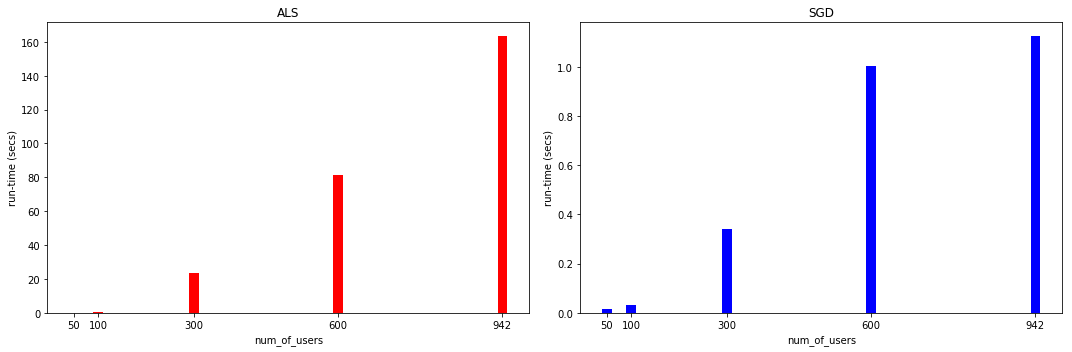

In [41]:
display_df_sgd=display_df[(display_df["algorithm"] == "SGD")]
display_df_sgd = display_df_sgd.reset_index()

display_df_als=display_df[(display_df["algorithm"] == "ALS")]
display_df_als = display_df_als.reset_index()


fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

plot_bar_chart(display_df_als,"num_of_users","run_time",ax[0],"r","ALS",'run-time (secs)')
plot_bar_chart(display_df_sgd,"num_of_users","run_time",ax[1],"b","SGD",'run-time (secs)')

plt.tight_layout()

We trained our algorithms using [50, 100, 300, 600, 942] users. As the number of users increased, the training time of ALS has significantly increased from less than a second to approximately 180 seconds. For SGD algorithm also, the training time has increased, but the range of increase is not significant. The training time of SGD has increased from less than a second to approximately 1.2 seconds. Hence from the run time perspective, SGD algorithm is significantly better than the ALS algorithm.


### Analyzing training error
The training error variation as the volume of data is displayed below:

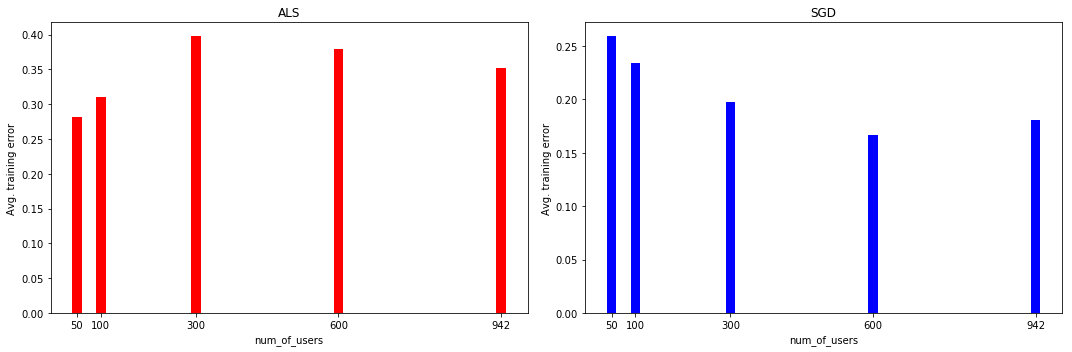

In [43]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

plot_bar_chart(display_df_als,"num_of_users","train_error",ax[0],"r","ALS","Avg. training error")
plot_bar_chart(display_df_sgd,"num_of_users","train_error",ax[1],"b","SGD","Avg. training error")
plt.tight_layout()

The average training errors range (for each set of users) is between 0.28 to 0.4 and 0.18 to 0.27 for ALS and SGD respectively. The training error range is less for SGD. It looks like there is no relationship between the average training error and the volume of the training data, since the training error for ALS has increased with the volume, but decreased from 600 users. For SGD, the training error decreased till 600 users and then increased at 942 users. 
Given the lower training error range for SGD, it is possible that SGD is overfitting the data.

### Analyzing test error
For each set of users, we divided the data into the 80:20 ratio, used the 80% of data for training and the 20% data for testing. The behavior of algorithms based on the test error can be summarized as given below:


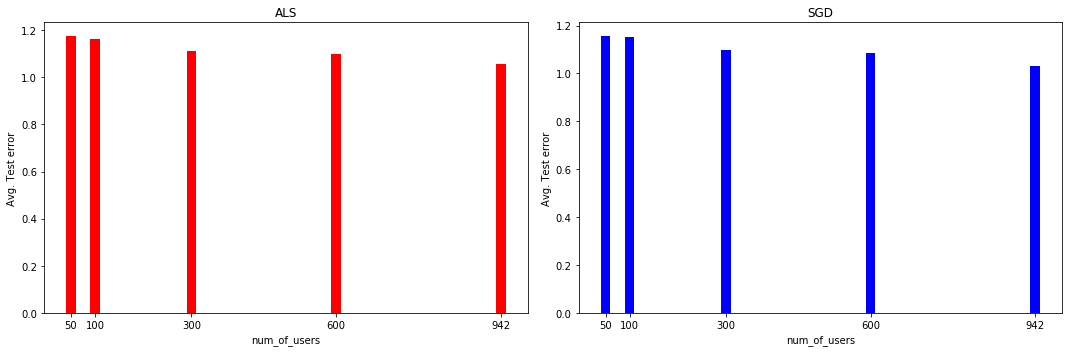

In [44]:

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

plot_bar_chart(display_df_als,"num_of_users","test_error",ax[0],"r","ALS","Avg. Test error")
plot_bar_chart(display_df_sgd,"num_of_users","test_error",ax[1],"b","SGD","Avg. Test error")
plt.tight_layout()



For both the algorithms, the test error decreased as the amount of training data increased. Also the range of errors are approximately same. 

### Analyzing the iterations

Let us analyze the average number of iterations needed to stabilize the error. Note that an iteration is defined as the the number of times the data is updated to converge the error. 

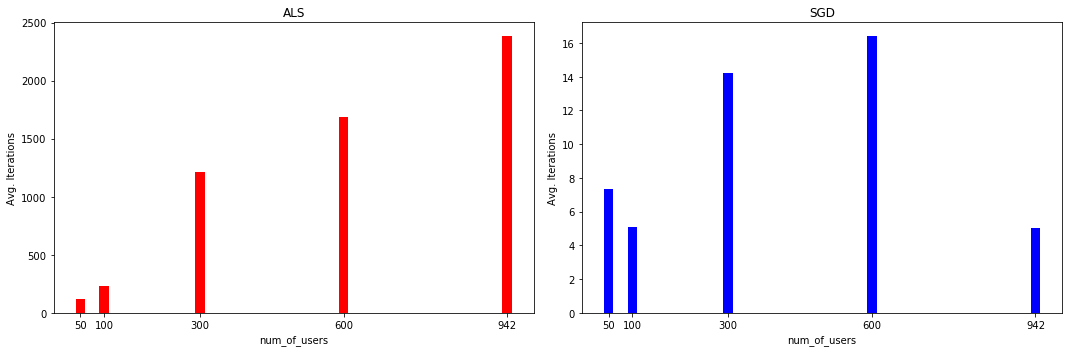

In [45]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

plot_bar_chart(display_df_als,"num_of_users","iterations",ax[0],"r","ALS","Avg. Iterations")
plot_bar_chart(display_df_sgd,"num_of_users","iterations",ax[1],"b","SGD","Avg. Iterations")


plt.tight_layout()

For ALS, the average number of iterations (needed to converge) the error has increased drastically from approximately 100 to 2400. For SGD the maximum number of iterations is approximately 16. Also for SGD, it looks like there is no relationship between the amount of data and the number of iterations needed. NOTE that for SGD and ALS, we initialized the data of U and V matrices using SVD method (assuming the NA values as 0 in the Utility matrix). Although not shown in this document, we also tested the algorithms using random values (std. normal distribution with mean 0 and variance 1). In that initialization, the SGD took a long time (or more iterations) to converge, while ALS is indifferent to the two methods of initialization.

### Analyzing the test error at the micro level

We will analyze the test error by plotting how it varied for both the methods for various combinations of parameters. We will segregate the performance data into two data frames for ALS and SGD, and analyze the performances.

In [50]:
#Create a separate data frame for ALS performance
als_display_df = performance_df[performance_df["algorithm"] == "ALS"]

#Create a separate data frame for SGD performance
sgd_display_df = performance_df[performance_df["algorithm"] == "SGD"]
#display(als_display_df.head())
#display(sgd_display_df.head())

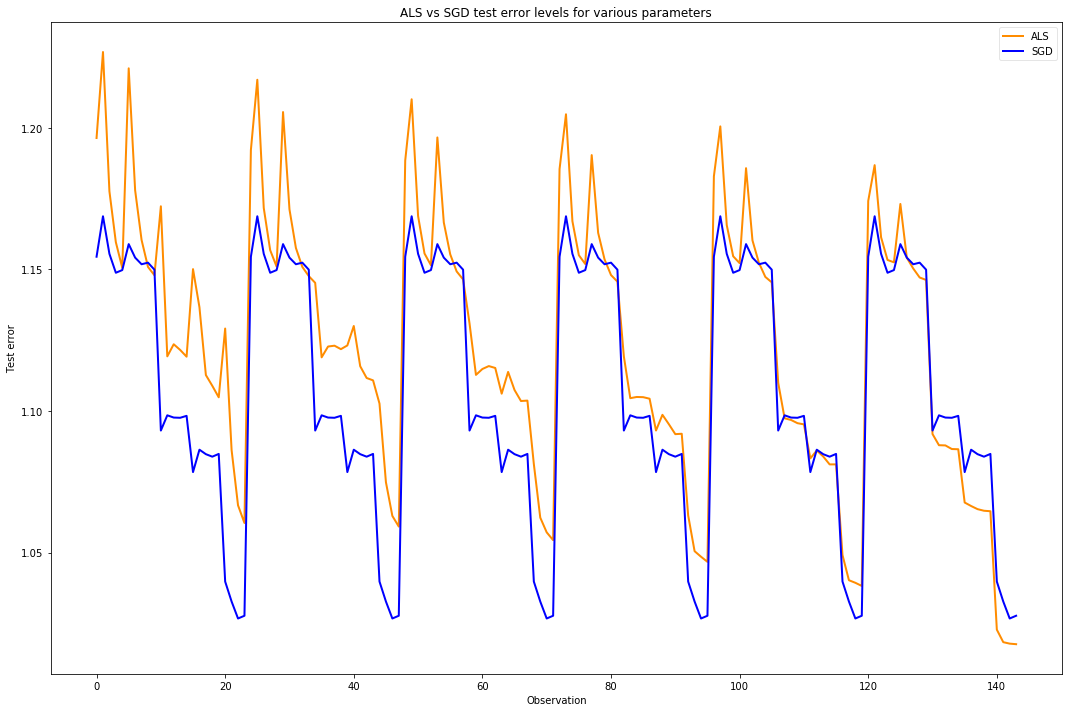

In [51]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(15,10))
lw=2
line1, = ax.plot(range(als_display_df.shape[0]),als_display_df["test_error"], color='darkorange',lw=lw, label='ALS')
line2, = ax.plot(range(sgd_display_df.shape[0]),sgd_display_df["test_error"], color='blue',lw=lw, label='SGD')

#line1, = ax.plot(als_display_df["reg"],als_display_df["test_error"], color='darkorange',lw=lw, label='ALS')
#line2, = ax.plot(sgd_display_df["reg"],sgd_display_df["test_error"], color='blue',lw=lw, label='SGD')

#line1, = ax.plot(als_display_df["latent_factors"],als_display_df["test_error"], color='darkorange',lw=lw, label='ALS')
#line2, = ax.plot(sgd_display_df["latent_factors"],sgd_display_df["test_error"], color='blue',lw=lw, label='SGD')

ax.set_title("ALS vs SGD test error levels for various parameters")
ax.set_ylabel('Test error')
ax.set_xlabel('Observation')
ax.legend(loc='upper right',fancybox=True, framealpha=0.5)
plt.tight_layout()

From the above plot, we can infer the following facts:
* The SGD algorithm is having consistently lower error range than the ALS algorithm
* The SGD algorithm has the same pattern or error range irrespective of the number of users
* The spikes represent the error caused due to variation of the parameters (regularization, and latent factors)
* The ALS algorithm's test error range has decreased as the amount of data has increased. 
* But overall SGD is superior since it has lower runtime and lower test error

Let us display the rows from the performance data, which have the least value of test errror.

In [52]:
print "Best parameters combinations for ALS, that resulted in minimal test error"
display(als_display_df.sort_values("test_error").head())

print "Best parameters combinations for SGD, that resulted in minimal test error"
display(sgd_display_df.sort_values("test_error").head())

Best parameters combinations for ALS, that resulted in minimal test error


,Unnamed: 0,algorithm,reg,num_of_users,latent_factors,run_time,train_error,test_error,iterations
287,287,ALS,10,942,476,234.974,0.721031,1.017646,2382
285,285,ALS,10,942,357,181.471,0.722531,1.017842,2382
283,283,ALS,10,942,238,136.900,0.724014,1.018361,2382
281,281,ALS,10,942,119,93.174,0.722156,1.022785,2382
239,239,ALS,5,942,476,243.485,0.436907,1.038216,2382


Best parameters combinations for SGD, that resulted in minimal test error


,Unnamed: 0,algorithm,reg,num_of_users,latent_factors,run_time,train_error,test_error,iterations
284,284,SGD,10,942,357,2.015,0.088389,1.026719,17
236,236,SGD,5,942,357,1.331,0.088390,1.026719,4
188,188,SGD,4,942,357,1.343,0.088390,1.026719,4
140,140,SGD,3,942,357,1.329,0.088390,1.026719,4
92,92,SGD,2,942,357,1.312,0.088390,1.026719,4


### Training the best possible models and evaluating the ROC Area
We will use the following parameters to train the ALS and SGD models and plot the ROC curves to identify which model has the superior performance. These are the parameters which are listed in the first rows of the above data frames:

In [53]:
df,ignore=select_data(user_df,942,20)
Utility = build_utility_matrix(df)
train_df,test_df=split_data(Utility,test_perc=20)
train_normalized,train_items_mean,train_users_mean = normalize(train_df)

SGD_U, SGD_V, SGD_train_error = SGD_factorization(np.array(train_normalized),357, 10, 10, 10000, 0.0000000001, 20,0.00001)
ALS_U, ALS_V, ALS_error = ALS_factorization(np.array(train_normalized),476, 10, 10, 10000, 0.0000000001, 20)

Adding the average item and user ratings (or denormalizing the predictions)

In [55]:
SGD_pred=np.dot(SGD_U,SGD_V)

SGD_pred = SGD_pred + train_items_mean
SGD_pred = SGD_pred.T + train_users_mean
SGD_pred = SGD_pred.T

ALS_pred=np.dot(ALS_U,ALS_V)

ALS_pred = ALS_pred + train_items_mean
ALS_pred = ALS_pred.T + train_users_mean
ALS_pred = ALS_pred.T


### Getting the test data predictions using ALS and SGD
The following code will get the predicted ratings for the test data using ALS and SGD methods. Whenever our model predicts a rating of more than 5, we change that rating to 5. Also we will normalize the ratings (divide all ratings by 5), so that the ratings would have a value between [0,1]. This can be intrepreted as the probability that a user likes the movie, and this interpretation will help us to plot the ROC curves for the two models.



In [59]:
SGD_predicted_ratings = get_ratings(pd.DataFrame(SGD_pred),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False)

ALS_predicted_ratings = get_ratings(pd.DataFrame(ALS_pred),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False)

SGD_predicted_ratings = np.array(SGD_predicted_ratings)
SGD_predicted_ratings[SGD_predicted_ratings > 5] = 5
SGD_predicted_prob = SGD_predicted_ratings/5
ALS_predicted_ratings = np.array(ALS_predicted_ratings)
ALS_predicted_ratings[ALS_predicted_ratings > 5] = 5
ALS_predicted_prob = ALS_predicted_ratings/5

#print SGD_predicted_ratings
#print SGD_predicted_prob

#print ALS_predicted_ratings
#print ALS_predicted_prob

Adding the predicted ratings and probabilities to the test data

In [60]:
test_df["SGD_predicted_ratings"] = SGD_predicted_ratings
test_df["SGD_predicted_prob"] = SGD_predicted_prob

test_df["ALS_predicted_ratings"] = ALS_predicted_ratings
test_df["ALS_predicted_prob"] = ALS_predicted_prob
test_df.head()

,row_number,column_number,user_id,item_id,rating,SGD_predicted_ratings,SGD_predicted_prob,ALS_predicted_ratings,ALS_predicted_prob
0,78,0,125,1,4.0,3.880880,0.776176,4.193376,0.838675
1,2,1,5,2,3.0,2.828458,0.565692,2.880354,0.576071
2,501,2,793,3,4.0,3.207344,0.641469,3.091344,0.618269
3,303,3,466,4,3.0,3.375976,0.675195,3.430438,0.686088
4,183,4,276,5,3.0,3.474997,0.694999,3.401084,0.680217


To make the ratings as binary prediction problem, we assume that a user likes the movie, if he gives a rating of more than 3, and dislikes the movie, if he rates the movie less than or equal to 3. Based on this assumption, we will add a new column "actually_liked" to the test data. This column will have a 1 if the user has given more than 3 rating to a movie, else this column will have 0.

In [61]:
actually_liked = test_df["rating"].copy() 
actually_liked[actually_liked <= 3] = 0
actually_liked[actually_liked > 3] = 1
test_df["actually_liked"]=actually_liked
test_df.head()

,row_number,column_number,user_id,item_id,rating,SGD_predicted_ratings,SGD_predicted_prob,ALS_predicted_ratings,ALS_predicted_prob,actually_liked
0,78,0,125,1,4.0,3.880880,0.776176,4.193376,0.838675,1.0
1,2,1,5,2,3.0,2.828458,0.565692,2.880354,0.576071,0.0
2,501,2,793,3,4.0,3.207344,0.641469,3.091344,0.618269,1.0
3,303,3,466,4,3.0,3.375976,0.675195,3.430438,0.686088,0.0
4,183,4,276,5,3.0,3.474997,0.694999,3.401084,0.680217,0.0


### Plotting ROC curves 
Using the AUC (Area Under the Curves) of ROC, we will make the final comparison of the algorithms performance.

SGD Area Under the Curve:0.786176870748
ALS Area Under the Curve:0.792954324587


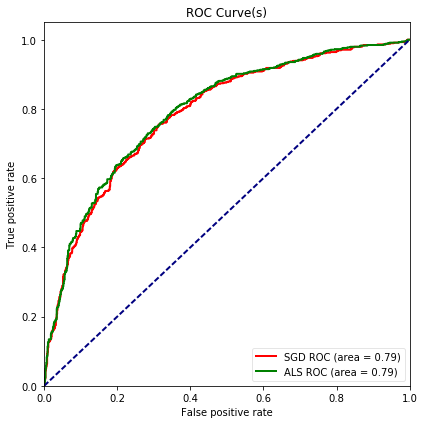

In [62]:
#Let us create a function to plot the ROC curves
def plot_roc_curves(fpr,tpr,ax,models,colors=["red","green","darkorange","green","black","magenta","cyan"]):
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    lw=2 #Line weight
    for key in range(len(fpr)):
        line1, = ax.plot(fpr[key], tpr[key], linewidth=2,color=colors[key],
                 label=models[key]+' ROC (area = %0.2f)' % auc(fpr[key],tpr[key]))
    line2,=ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.legend(loc='lower right',fancybox=True, framealpha=0.5)
    
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    ax.set_title('ROC Curve(s)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    return ax






from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Dictionary to collect the False Positive Rates at various probabilities thresholds
fpr = dict()

#Dictionary to collect the True Positive Rates at various probabilities thresholds
tpr = dict()

#Dictionary to collect the probability thresholds used to compute the TPR and FPR
thresholds=dict()

#Get the probabilities that the target class=1 (income > 50K) using unoptimized classifier
#clf_test_scores=np.array(pd.DataFrame(clf.predict_proba(X_test))[1])
SGD_clf_test_scores=np.array(test_df["SGD_predicted_prob"])

#Get the FPR, TPR, thresholds used for unoptimized classifier
fpr[0], tpr[0], thresholds[0] = roc_curve(test_df["actually_liked"], y_score=SGD_clf_test_scores, pos_label=1)

#Get the probabilities that the target class=1 (income > 50K) using optimized classifier
ALS_clf_test_scores=np.array(test_df["ALS_predicted_prob"])

#Get the FPR, TPR, thresholds used for optimized classifier
fpr[1], tpr[1], thresholds[1] = roc_curve(test_df["actually_liked"], y_score=ALS_clf_test_scores, pos_label=1)


print "SGD Area Under the Curve:" + str(auc(fpr[0],tpr[0]))
print "ALS Area Under the Curve:" + str(auc(fpr[1],tpr[1]))


    
    
fig, ax = plt.subplots(figsize=(6,6))
#fig.suptitle('Categorical variables bar plots')
models=["SGD", "ALS"]
plot_roc_curves(fpr,tpr,ax,models)
plt.tight_layout()

The area under the ROC curves is approximately equal for both SGD and ALS methods. But given that the run time of SGD is very low compared to the ALS method, we propose SGD as the best algorithm for recommendation systems based on the matrix factorization methods. But it must be noted that our conclusions are based on the results of running the algorithms on a laptop with 6GB RAM. But ALS method might give superior performance if they are run on Big data systems such as Spark, since we can parallelize the operations.

## Conclusion

In this project, we evaluated the Alternating Least Squares (ALS) method and Stochastic Gradient Descent (SGD) method to factorize the utility matrix, and evaluated the algorithms performance on the test data. We used 3 metrics to evaluate the algorithms: RMSE, Run-time and AUC of ROC. Based on all the evaluated metrics we concluded that SGD is having better run-times. In both the methods, we are able to obtain a test error (RMSE) of approximately 1.02. But both of these methods suffer from the cold-start problem. So, as a part of future work, we will implement Regression Based Latent Factor methods, which could reduce the RMSE error further, and can also successfully address cold-start problem.

### References:
1. F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

2. Jure Leskovec, Anand Rajaraman and Jeffrey D. Ullman 2014. Mining of Massive Datasets (Chapter 9)

3. Deepak K. Agarwal and Bee-Chung Chen. Statistical Methods for Recommender Systems